# Photoz with Deep probabilistic neural network


- Evaluate 10 models

- author : Sylvie Dagoret-Campagne
- creation : 2023/05/06
- update : 2023/05/07

### Dependencies & Prerequisites


In [1]:
#@title Import { display-mode: "form" }

from IPython import display

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

from tensorflow import keras
from keras.models import Sequential,Model 
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras import layers
from keras import Input

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
tfpl = tfp.layers

2023-05-07 15:53:59.404275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import pandas as pd
import os,sys
import h5py
import copy

In [3]:
def getdataerror(hf):
    key_sel = list(hf.keys())[0]
    group = hf.get(key_sel)
    
    mag_err_u_lsst = np.array(group.get("mag_err_u_lsst"))
    mag_err_g_lsst = np.array(group.get("mag_err_g_lsst"))
    mag_err_r_lsst = np.array(group.get("mag_err_r_lsst"))
    mag_err_i_lsst = np.array(group.get("mag_err_i_lsst"))
    mag_err_z_lsst = np.array(group.get("mag_err_z_lsst"))
    mag_err_y_lsst = np.array(group.get("mag_err_y_lsst"))
    mag_u_lsst =  np.array(group.get("mag_u_lsst"))
    mag_g_lsst =  np.array(group.get("mag_g_lsst"))
    mag_r_lsst =  np.array(group.get("mag_r_lsst"))
    mag_i_lsst =  np.array(group.get("mag_i_lsst"))
    mag_z_lsst =  np.array(group.get("mag_z_lsst"))
    mag_y_lsst =  np.array(group.get("mag_y_lsst"))
    redshift = np.array(group.get("redshift"))
    
    data = np.vstack((
                    mag_u_lsst, 
                    mag_g_lsst, 
                    mag_r_lsst, 
                    mag_i_lsst, 
                    mag_z_lsst,
                    mag_y_lsst,
                    mag_err_u_lsst, 
                    mag_err_g_lsst, 
                    mag_err_r_lsst, 
                    mag_err_i_lsst, 
                    mag_err_z_lsst,
                    mag_err_y_lsst,
                    redshift)) 
    data = data.T
    indexes_bad = np.where(data[:,0]>40)[0]
    datacut = np.delete(data,indexes_bad,axis=0)
    features = datacut[:,0:6]
    errors = datacut[:,6:-1]
    targets = datacut[:,-1]
    return features,errors,targets    

In [4]:
input_train_file_h5 = "../data/test_dc2_training_9816.hdf5"
input_test_file_h5 = "../data/test_dc2_validation_9816.hdf5"

In [5]:
hftrain =  h5py.File(input_train_file_h5, 'r') 
hftest =  h5py.File(input_test_file_h5, 'r') 

In [6]:
# swap train and test because more example in validation
x_train0,x_train_error0,y_train = getdataerror(hftest)
x_test0,x_test_error0,y_test = getdataerror(hftrain)

In [7]:
NBANDS = x_train0.shape[1]
NSAMPLES = x_train0.shape[0]
NSIM= 1

In [8]:
def simulatesamples(x,ex,nsim=NSIM):
    nsamples = x.shape[0]
    nbands = x.shape[1]
    
    all_samples = np.zeros((nsamples,nbands,nsim))
    for idx in range(nbands):
        mean = x[:,idx]
        sig = ex[:,idx]
        simdata = np.random.normal(mean, sig, (nsim,nsamples))
        all_samples[:,idx,: ] = simdata.T
    return all_samples  

In [9]:
train_data = simulatesamples(x_train0,x_train_error0,NSIM)
test_data = simulatesamples(x_test0,x_test_error0,NSIM)

In [10]:
mean = np.mean(train_data[:,:,0],axis=0)
std  = np.std(train_data[:,:,0],axis=0)

In [11]:
x_train0 = train_data[:,:,0]
x_test0 = test_data[:,:,0]

In [12]:
x_train0_norm = (x_train0-mean)/std
x_test0_norm = (x_test0-mean)/std

In [13]:
all_x_train_norm = []
all_x_test_norm = []
for isim in range(NSIM):
    x_train_norm = (train_data[:,:,isim] - mean)/std
    x_test_norm = (test_data[:,:,isim] - mean)/std
    all_x_train_norm.append(x_train_norm) 
    all_x_test_norm.append(x_test_norm) 

In [14]:
x_train = copy.deepcopy(all_x_train_norm[0])
x_test = copy.deepcopy(all_x_test_norm[0])
y_train = copy.deepcopy(y_train[:,np.newaxis])
y_test = copy.deepcopy(y_test[:,np.newaxis])

## presentation of results

In [15]:
def get_stats(z_spec,z_phot,slope=0.15):
    """
    input : 
       - z_spec : spectroscopic redshift or true redshift
       - z_phot : photo-z reedshift
       - slope : slope of line defining the outliers  3 x sigma_z with sigma_z = 5%, so slope = 3 x 0.05 = 0.15 
    """
    
    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > slope
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)
    

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    
     # overlay statistics with titles left-aligned and numbers right-aligned
    stats_txt = '\n'.join([
        'NMAD  = {:0.2f}'.format(nmad),
        'STDEV = {:0.2f}'.format(std_result),
        'BIAS  = {:0.2f}'.format(bias),
        'ETA   = {:0.2f}'.format(eta)
    ])
    
    
    return nmad,std_result,bias,eta,stats_txt

In [16]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

In [17]:
def plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15):
    x = np.arange(zmin,zmax,zstep)
    outlier_upper = x + slope*(1+x)
    outlier_lower = x - slope*(1+x)
    return x,outlier_upper,outlier_lower

## Tensorflow callbacks

In [18]:
# Early Stopping Callback
earlystopping_cbk = EarlyStopping(monitor='loss', patience=20, min_delta=0, mode='auto', baseline=None, restore_best_weights=True)
reducelronplateau_cbk = ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=10)

In [19]:
callbacks_list = [reducelronplateau_cbk]

## The model

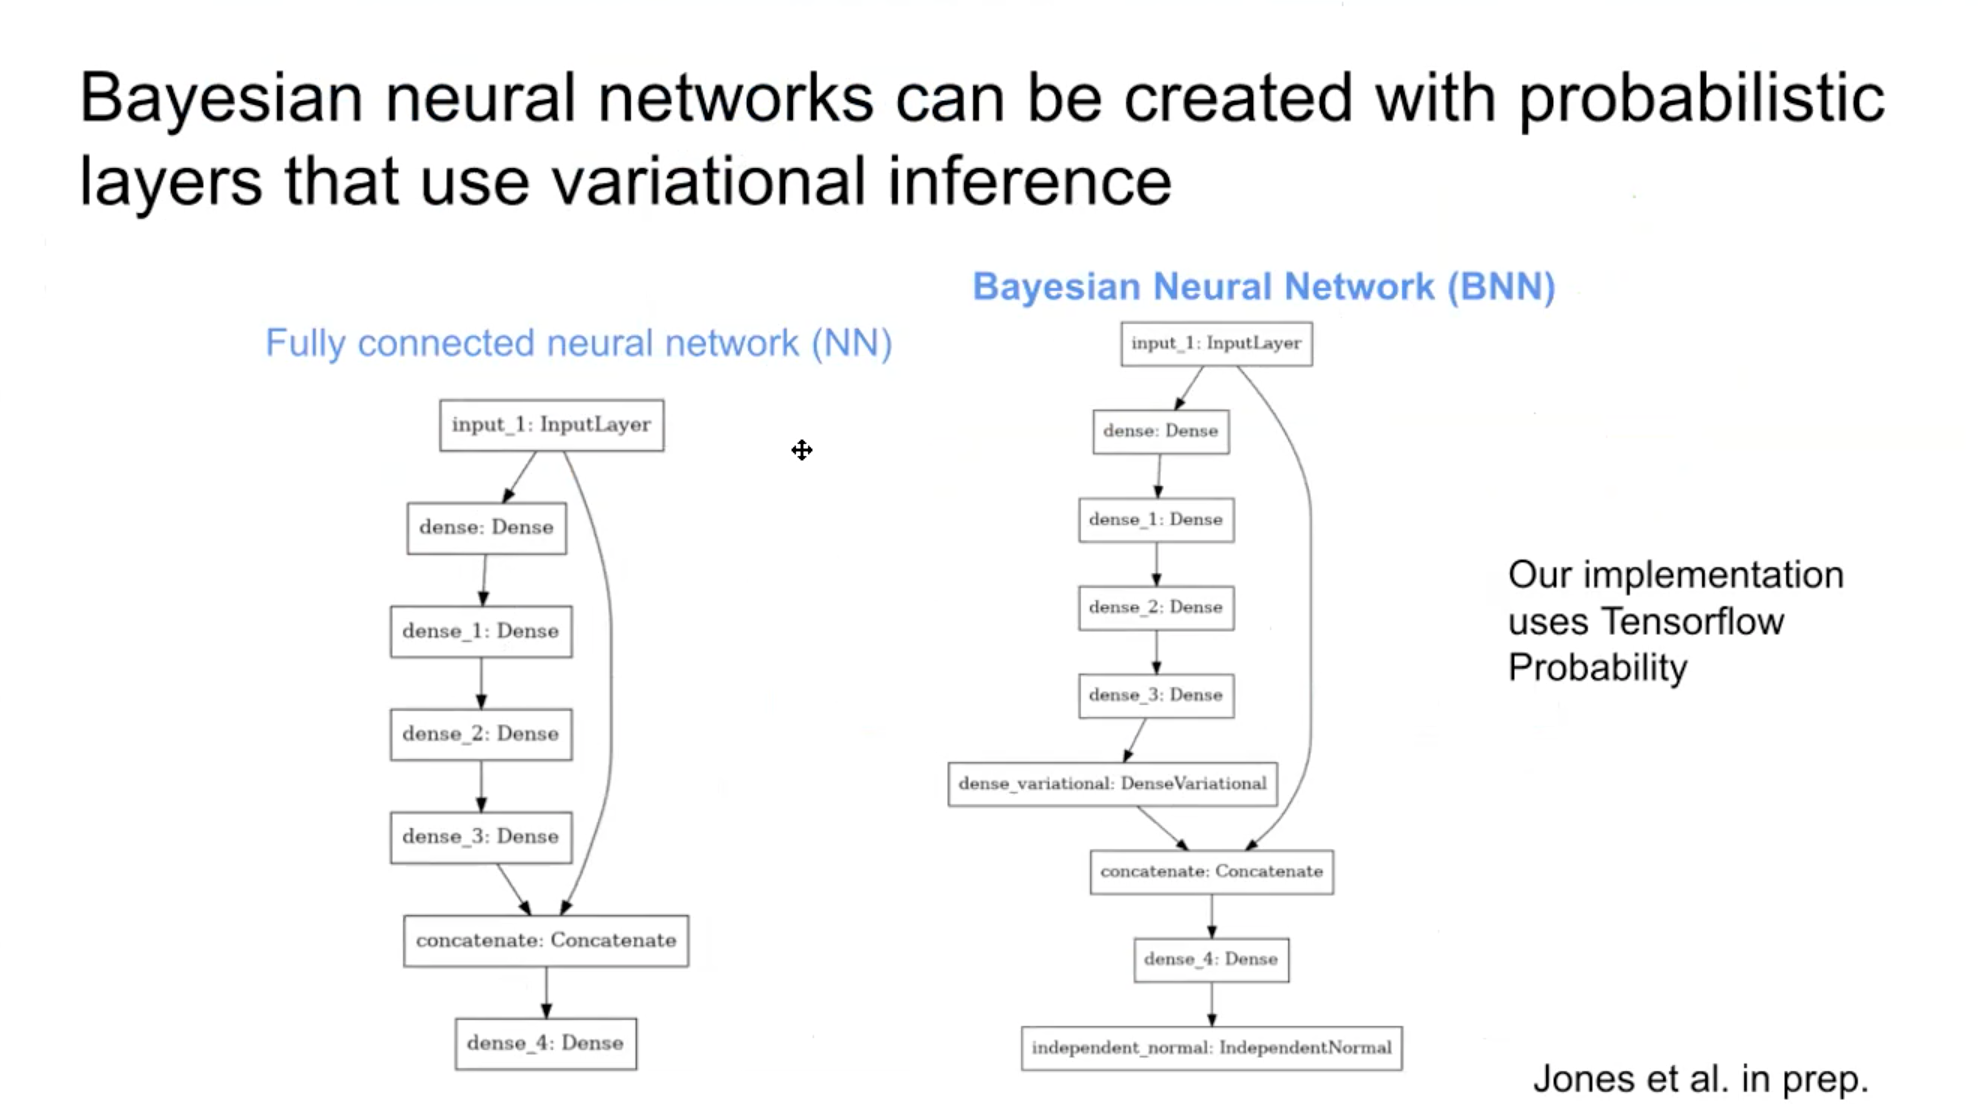

In [20]:
display.Image("Figs/Fig_BauesianNetwork.png")

## Motivation

Wouldn't it be great if we could use TFP to specify a probabilistic model then simply minimize the negative log-likelihood, i.e.,

In [21]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [22]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [23]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

# Model 1

In [24]:
def get_model_v1(n_samples):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input((6,), name="InputLayer"))
  model.add(keras.layers.Dense(32, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n3'))
  model.add(keras.layers.Dense(32, activation="relu", name='Dense_n4'))
  model.add(tfp.layers.DenseVariational(32 + 32, posterior_mean_field, prior_trainable, kl_weight=1/n_samples))
  model.add(keras.layers.Dense(1,  name='Dense_n5'))
  model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))
    
          
  #model.add(tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
  #                            make_prior_fn=prior_trainable,
  #                            make_posterior_fn=posterior_mean_field,
  #                            kl_use_exact=False,
  #                            kl_weight=1/n_samples))

        # Aleatoric uncertainty
  #model.add(tfpl.IndependentNormal(1))
    
  
  model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01),
                loss      = negloglik )
  return model

In [25]:
n_samples = x_train.shape[0]
model1 = get_model_v1(n_samples)

In [26]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 32)                224       
                                                                 
 Dense_n2 (Dense)            (None, 64)                2112      
                                                                 
 Dense_n3 (Dense)            (None, 64)                4160      
                                                                 
 Dense_n4 (Dense)            (None, 32)                2080      
                                                                 
 dense_variational (DenseVa  (None, 64)                6336      
 riational)                                                      
                                                                 
 Dense_n5 (Dense)            (None, 1)                 65        
                                                        

In [27]:
# Fit
history = model1.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=50, verbose=1)

Epoch 1/50
593/593 [==============================] - 3s 3ms/step - loss: 1.1861 - val_loss: 0.9811
Epoch 2/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9833 - val_loss: 0.9737
Epoch 3/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9731 - val_loss: 0.9608
Epoch 4/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9686 - val_loss: 0.9984
Epoch 5/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9528 - val_loss: 0.9489
Epoch 6/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9498 - val_loss: 0.9439
Epoch 7/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9503 - val_loss: 0.9471
Epoch 8/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9496 - val_loss: 0.9563
Epoch 9/50
593/593 [==============================] - 1s 3ms/step - loss: 0.9480 - val_loss: 0.9458
Epoch 10/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9446 - val_loss: 0.9467

Text(0.5, 1.0, 'Model 1 : Loss')

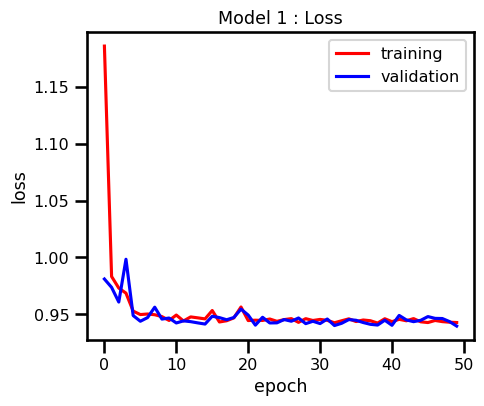

In [28]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 1 : Loss")
#ax.set_yscale('log')

In [29]:
y_pred_train = model1(x_train).sample()
y_pred_test = model1(x_test).sample()

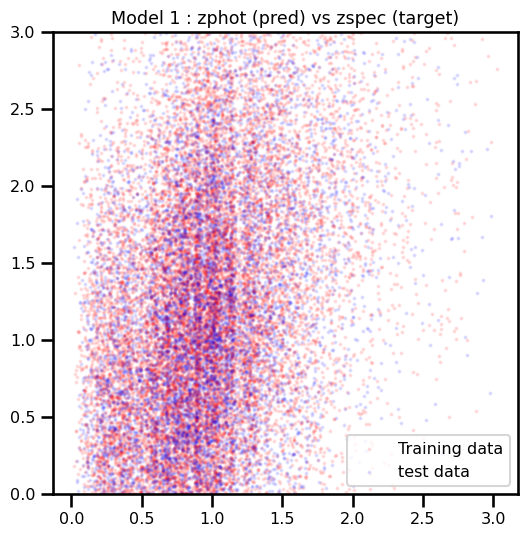

In [30]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r',s=2 ,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2 ,label='test data')
ax.set_title("Model 1 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

# Model 2

In [31]:
def get_model_v2(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(32, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(64, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(64, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(32, activation="relu", name='Dense_n4')(x)
    x = tfp.layers.DenseVariational(32 + 32, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid')(x)
    x = keras.layers.Dense(1,  name='Dense_n5')(x)
    output_proba = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))(x)
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [32]:
n_samples = x_train.shape[0]
model2 = get_model_v2(n_samples)

In [33]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 6)]               0         
                                                                 
 Dense_n1 (Dense)            (None, 32)                224       
                                                                 
 Dense_n2 (Dense)            (None, 64)                2112      
                                                                 
 Dense_n3 (Dense)            (None, 64)                4160      
                                                                 
 Dense_n4 (Dense)            (None, 32)                2080      
                                                                 
 dense_variational_1 (Dense  (None, 64)                6336      
 Variational)                                                    
                                                             

In [34]:
# Fit
history = model2.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=50, verbose=1)

Epoch 1/50
593/593 [==============================] - 4s 4ms/step - loss: 0.9991 - val_loss: 0.9639
Epoch 2/50
593/593 [==============================] - 2s 3ms/step - loss: 0.9508 - val_loss: 0.9438
Epoch 3/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9453 - val_loss: 0.9465
Epoch 4/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9433 - val_loss: 0.9356
Epoch 5/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9415 - val_loss: 0.9378
Epoch 6/50
593/593 [==============================] - 2s 3ms/step - loss: 0.9408 - val_loss: 0.9406
Epoch 7/50
593/593 [==============================] - 2s 3ms/step - loss: 0.9411 - val_loss: 0.9369
Epoch 8/50
593/593 [==============================] - 2s 3ms/step - loss: 0.9411 - val_loss: 0.9392
Epoch 9/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9403 - val_loss: 0.9378
Epoch 10/50
593/593 [==============================] - 1s 2ms/step - loss: 0.9391 - val_loss: 0.9372

Text(0.5, 1.0, 'Model 2 Loss')

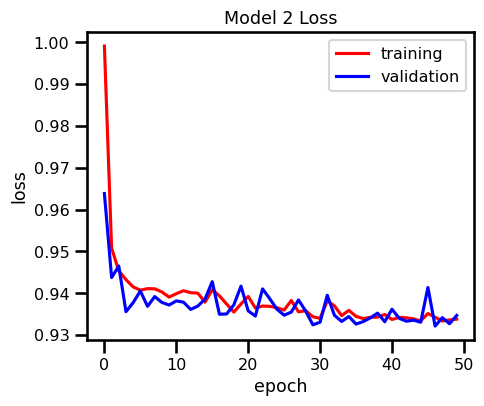

In [35]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 2 Loss")
#ax.set_yscale('log')

In [36]:
y_pred_train = model2(x_train).sample()
y_pred_test = model2(x_test).sample()

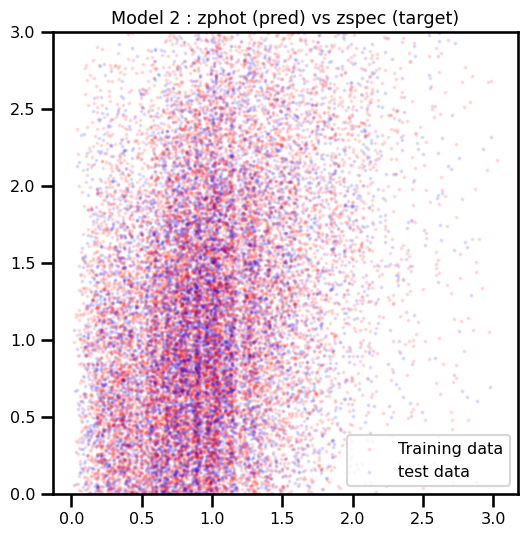

In [37]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b',s=2 ,label='test data')
ax.set_title("Model 2 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

# Model 3

In [38]:
def get_model_v3(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(32, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(64, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(128, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(64, activation="relu", name='Dense_n4')(x)
    x = tfp.layers.DenseVariational(64 + 64, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational64')(x)
    x = keras.layers.Dense(1,  name='Dense_n5')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [39]:
n_samples = x_train.shape[0]
model3 = get_model_v3(n_samples)

In [40]:
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 6)]               0         
                                                                 
 Dense_n1 (Dense)            (None, 32)                224       
                                                                 
 Dense_n2 (Dense)            (None, 64)                2112      
                                                                 
 Dense_n3 (Dense)            (None, 128)               8320      
                                                                 
 Dense_n4 (Dense)            (None, 64)                8256      
                                                                 
 DenseVariational64 (DenseV  (None, 128)               24960     
 ariational)                                                     
                                                           

In [41]:
# Fit
history = model3.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

Epoch 1/200
593/593 [==============================] - 4s 4ms/step - loss: 34.3098 - val_loss: 6.0173 - lr: 0.0100
Epoch 2/200
593/593 [==============================] - 2s 3ms/step - loss: 4.0551 - val_loss: 7.1276 - lr: 0.0100
Epoch 3/200
593/593 [==============================] - 2s 4ms/step - loss: 2845.2729 - val_loss: 25.4040 - lr: 0.0100
Epoch 4/200
593/593 [==============================] - 2s 3ms/step - loss: 15.2870 - val_loss: 2.3963 - lr: 0.0100
Epoch 5/200
593/593 [==============================] - 2s 3ms/step - loss: 3.0693 - val_loss: 2.0056 - lr: 0.0100
Epoch 6/200
593/593 [==============================] - 2s 3ms/step - loss: 2.1292 - val_loss: 2.2850 - lr: 0.0100
Epoch 7/200
593/593 [==============================] - 2s 3ms/step - loss: 2.2995 - val_loss: 2.0070 - lr: 0.0100
Epoch 8/200
593/593 [==============================] - 2s 3ms/step - loss: 2.0335 - val_loss: 2.2055 - lr: 0.0100
Epoch 9/200
593/593 [==============================] - 2s 3ms/step - loss: 2.1054 

Text(0.5, 1.0, 'Model 3 : Loss')

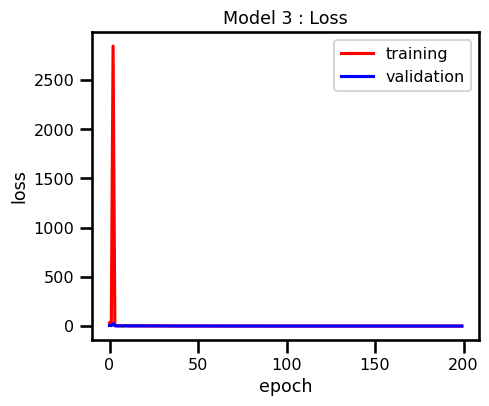

In [42]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 3 : Loss")
#ax.set_yscale('log')

In [43]:
y_pred_train = model3(x_train).sample()
y_pred_test = model3(x_test).sample()

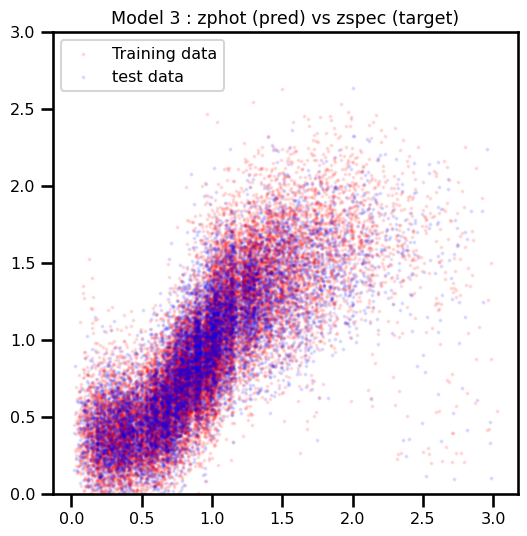

In [44]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b',s=2 ,label='test data')
ax.set_title("Model 3 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [45]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 0.1557
Normalized MAD: 0.1460
Delta z >0.15(1+z) outliers: 31.153 percent
Median offset: -0.017 +/-  0.002


In [46]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

(0.0, 3.0)

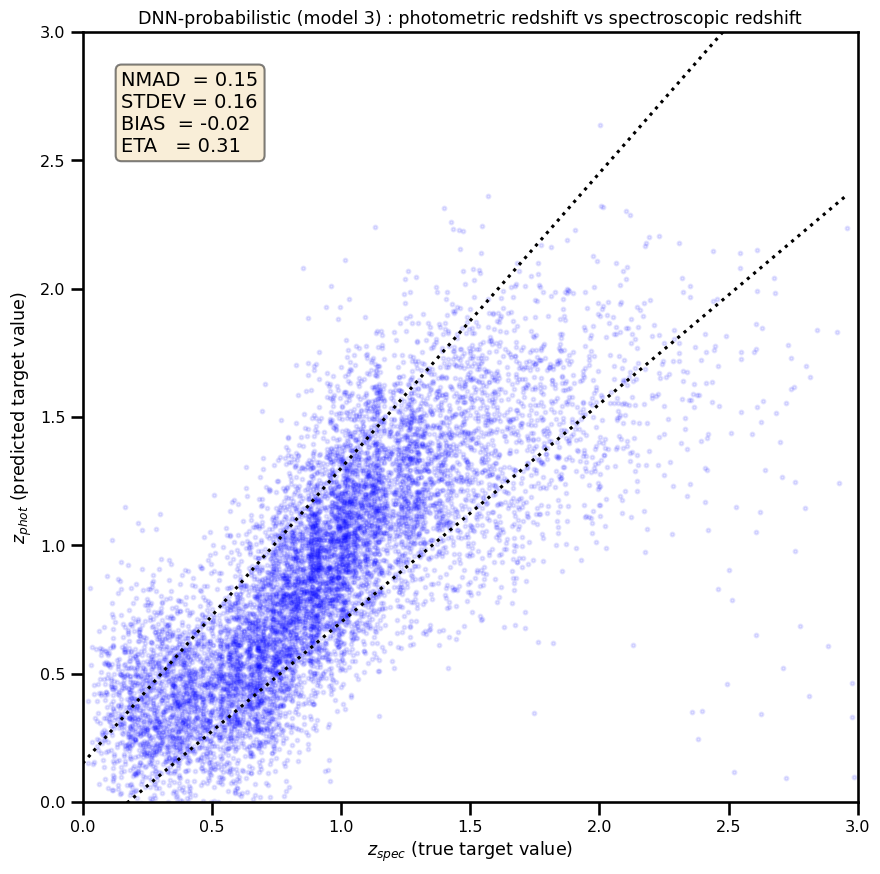

In [47]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 3) : photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

# Model 4

In [48]:
def get_model_v4(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(32, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(64, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(128, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(64, activation="relu", name='Dense_n4')(x)
    x = tfp.layers.DenseVariational(64 + 64, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational64')(x)
    
    
    concatenated = keras.layers.concatenate([x,input_tensor],axis=-1)
    #
    x = keras.layers.Dense(2, activation="relu", name='Dense_n5')(concatenated) # need activation to stabilize, unit =2 --> loss 0.67
    #x = keras.layers.Dense(1, name='Dense_n5')(concatenated)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty
    #output_proba = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))(x)
    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [49]:
n_samples = x_train.shape[0]
model4 = get_model_v4(n_samples)

In [50]:
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLayer (InputLayer)     [(None, 6)]                  0         []                            
                                                                                                  
 Dense_n1 (Dense)            (None, 32)                   224       ['InputLayer[0][0]']          
                                                                                                  
 Dense_n2 (Dense)            (None, 64)                   2112      ['Dense_n1[0][0]']            
                                                                                                  
 Dense_n3 (Dense)            (None, 128)                  8320      ['Dense_n2[0][0]']            
                                                                                            

In [51]:
# Fit
history = model4.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

Epoch 1/200
593/593 [==============================] - 5s 3ms/step - loss: 2.6435 - val_loss: 1.4486 - lr: 0.0100
Epoch 2/200
593/593 [==============================] - 2s 3ms/step - loss: 1.2514 - val_loss: 1.1702 - lr: 0.0100
Epoch 3/200
593/593 [==============================] - 2s 3ms/step - loss: 1.0895 - val_loss: 1.1154 - lr: 0.0100
Epoch 4/200
593/593 [==============================] - 2s 3ms/step - loss: 0.9966 - val_loss: 0.9358 - lr: 0.0100
Epoch 5/200
593/593 [==============================] - 2s 3ms/step - loss: 0.9146 - val_loss: 0.8550 - lr: 0.0100
Epoch 6/200
593/593 [==============================] - 2s 3ms/step - loss: 0.8429 - val_loss: 0.8171 - lr: 0.0100
Epoch 7/200
593/593 [==============================] - 2s 3ms/step - loss: 0.7635 - val_loss: 0.7873 - lr: 0.0100
Epoch 8/200
593/593 [==============================] - 2s 3ms/step - loss: 0.7496 - val_loss: 0.7516 - lr: 0.0100
Epoch 9/200
593/593 [==============================] - 2s 3ms/step - loss: 0.7187 - val_

Text(0.5, 1.0, 'Model 4 : Loss')

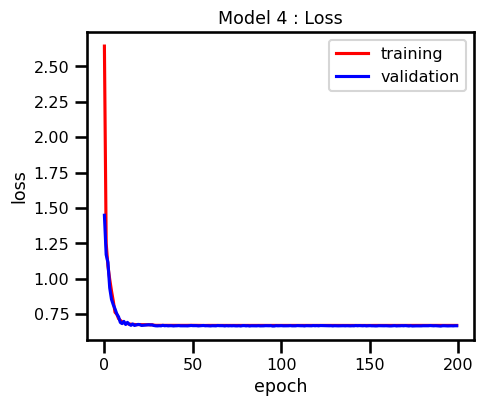

In [52]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 4 : Loss")
#ax.set_yscale('log')

In [53]:
y_pred_train = model4(x_train).sample()
y_pred_test = model4(x_test).sample()

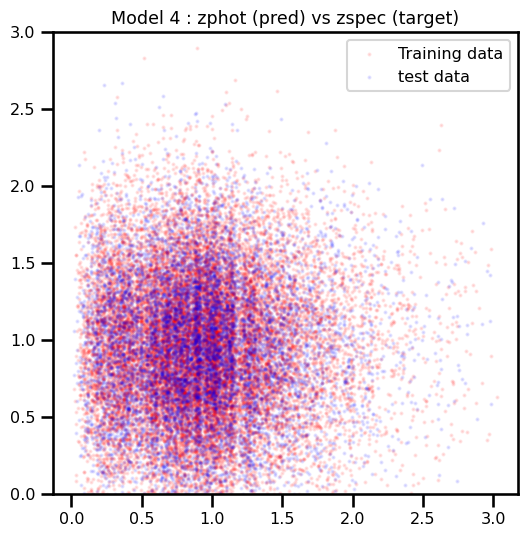

In [54]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 4 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [55]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 0.3726
Normalized MAD: 0.3450
Delta z >0.15(1+z) outliers: 66.239 percent
Median offset:  0.011 +/-  0.005


In [56]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

(0.0, 3.0)

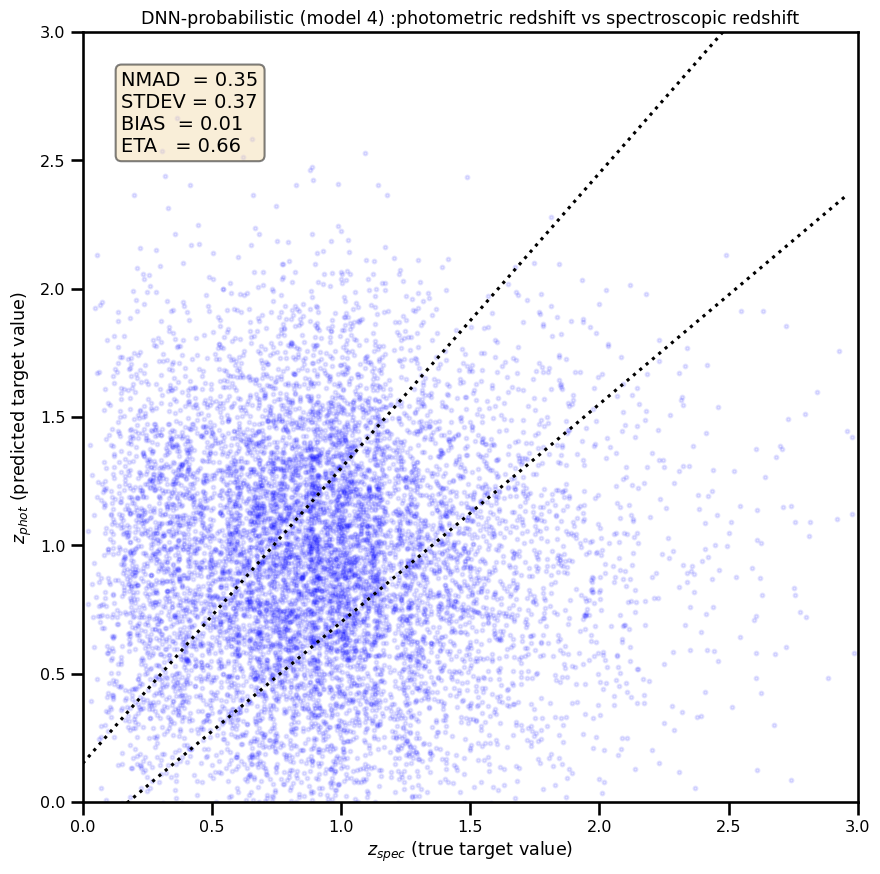

In [57]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 4) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

# Model 5

In [58]:
def get_model_v5(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(16, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(32, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(64, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(32, activation="relu", name='Dense_n4')(x)
    x = tfp.layers.DenseVariational(32 + 32, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational32')(x)
    x = keras.layers.Dense(1,  name='Dense_n5')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [59]:
n_samples = x_train.shape[0]
model5 = get_model_v5(n_samples)

In [60]:
model5.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 6)]               0         
                                                                 
 Dense_n1 (Dense)            (None, 16)                112       
                                                                 
 Dense_n2 (Dense)            (None, 32)                544       
                                                                 
 Dense_n3 (Dense)            (None, 64)                2112      
                                                                 
 Dense_n4 (Dense)            (None, 32)                2080      
                                                                 
 DenseVariational32 (DenseV  (None, 64)                6336      
 ariational)                                                     
                                                           

In [61]:
# Fit
history = model5.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

Epoch 1/200
593/593 [==============================] - 5s 5ms/step - loss: 14.2551 - val_loss: 1.8855 - lr: 0.0100
Epoch 2/200
593/593 [==============================] - 2s 4ms/step - loss: 1.7215 - val_loss: 1.7890 - lr: 0.0100
Epoch 3/200
593/593 [==============================] - 2s 3ms/step - loss: 1.6674 - val_loss: 1.6914 - lr: 0.0100
Epoch 4/200
593/593 [==============================] - 2s 3ms/step - loss: 1.6069 - val_loss: 1.5482 - lr: 0.0100
Epoch 5/200
593/593 [==============================] - 2s 3ms/step - loss: 1.4745 - val_loss: 1.4323 - lr: 0.0100
Epoch 6/200
593/593 [==============================] - 3s 5ms/step - loss: 1.4885 - val_loss: 1.4223 - lr: 0.0100
Epoch 7/200
593/593 [==============================] - 2s 3ms/step - loss: 1.3374 - val_loss: 1.2174 - lr: 0.0100
Epoch 8/200
593/593 [==============================] - 2s 3ms/step - loss: 1.3006 - val_loss: 1.2270 - lr: 0.0100
Epoch 9/200
593/593 [==============================] - 1s 2ms/step - loss: 1.1552 - val

Text(0.5, 1.0, 'Model 5 : Loss')

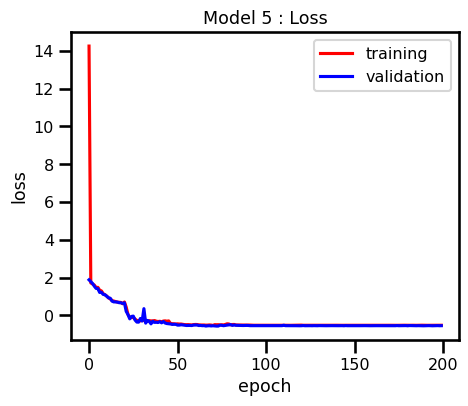

In [62]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 5 : Loss")
#ax.set_yscale('log')

In [63]:
y_pred_train = model5(x_train).sample()
y_pred_test = model5(x_test).sample()

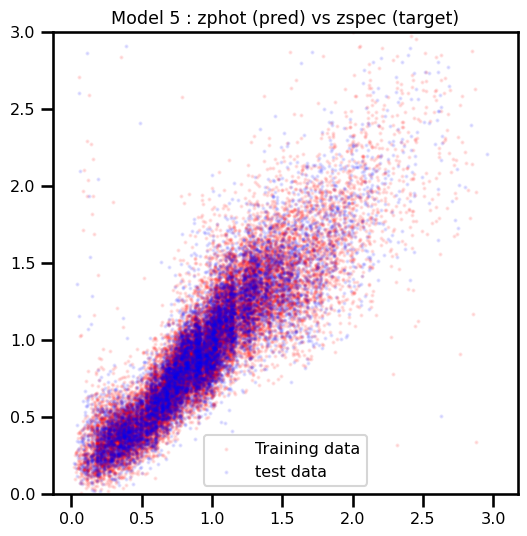

In [64]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 5 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [65]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 0.8292
Normalized MAD: 0.0949
Delta z >0.15(1+z) outliers: 13.658 percent
Median offset: -0.001 +/-  0.011


In [66]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

(0.0, 3.0)

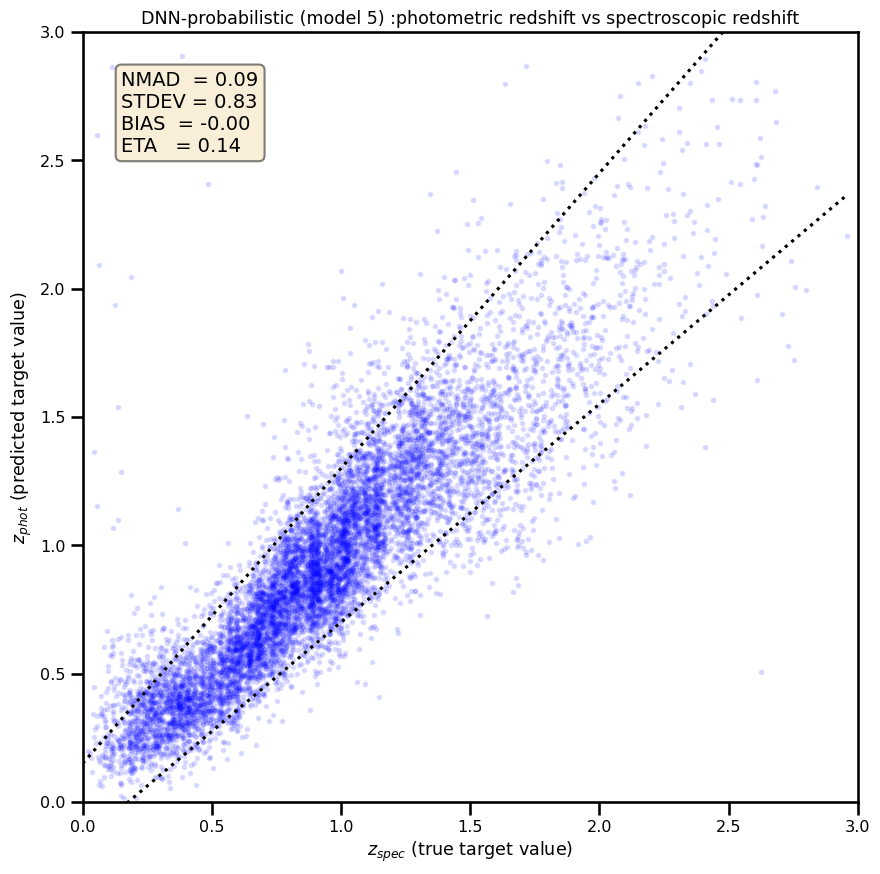

In [67]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 5) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

# Model 6

In [68]:
def get_model_v6(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(8, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(16, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(32, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(16, activation="relu", name='Dense_n4')(x)
    x = tfp.layers.DenseVariational(16 + 16, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational16')(x)
    x = keras.layers.Dense(1,  name='Dense_n5')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [69]:
n_samples = x_train.shape[0]
model6 = get_model_v6(n_samples)

In [70]:
model6.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 6)]               0         
                                                                 
 Dense_n1 (Dense)            (None, 8)                 56        
                                                                 
 Dense_n2 (Dense)            (None, 16)                144       
                                                                 
 Dense_n3 (Dense)            (None, 32)                544       
                                                                 
 Dense_n4 (Dense)            (None, 16)                528       
                                                                 
 DenseVariational16 (DenseV  (None, 32)                1632      
 ariational)                                                     
                                                           

In [71]:
# Fit
history = model6.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

Epoch 1/200
593/593 [==============================] - 4s 3ms/step - loss: 4.2532 - val_loss: 1.5718 - lr: 0.0100
Epoch 2/200
593/593 [==============================] - 1s 2ms/step - loss: 1.4926 - val_loss: 1.3926 - lr: 0.0100
Epoch 3/200
593/593 [==============================] - 2s 3ms/step - loss: 1.2469 - val_loss: 1.1874 - lr: 0.0100
Epoch 4/200
593/593 [==============================] - 2s 3ms/step - loss: 1.1608 - val_loss: 1.1417 - lr: 0.0100
Epoch 5/200
593/593 [==============================] - 2s 3ms/step - loss: 1.0443 - val_loss: 0.9971 - lr: 0.0100
Epoch 6/200
593/593 [==============================] - 1s 2ms/step - loss: 0.9562 - val_loss: 0.9309 - lr: 0.0100
Epoch 7/200
593/593 [==============================] - 1s 2ms/step - loss: 0.8665 - val_loss: 0.8755 - lr: 0.0100
Epoch 8/200
593/593 [==============================] - 1s 2ms/step - loss: 0.8163 - val_loss: 0.8220 - lr: 0.0100
Epoch 9/200
593/593 [==============================] - 1s 2ms/step - loss: 0.7607 - val_

Text(0.5, 1.0, 'Model 6 : Loss')

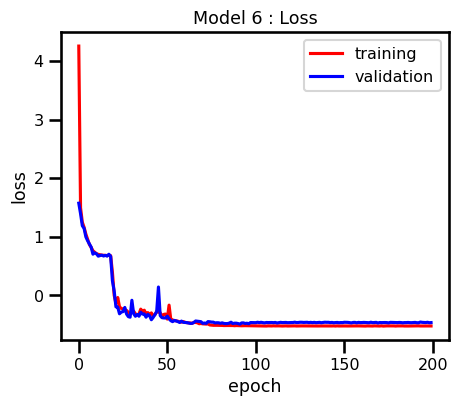

In [72]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 6 : Loss")
#ax.set_yscale('log')

In [73]:
y_pred_train = model6(x_train).sample()
y_pred_test = model6(x_test).sample()

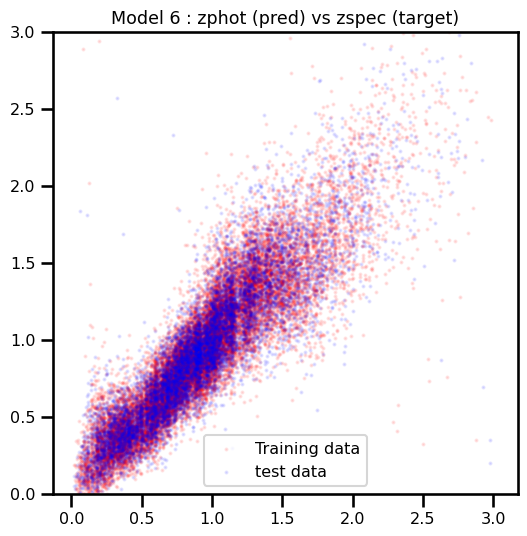

In [74]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 6 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [75]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 0.2970
Normalized MAD: 0.0951
Delta z >0.15(1+z) outliers: 13.637 percent
Median offset:  0.002 +/-  0.004


In [76]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

(0.0, 3.0)

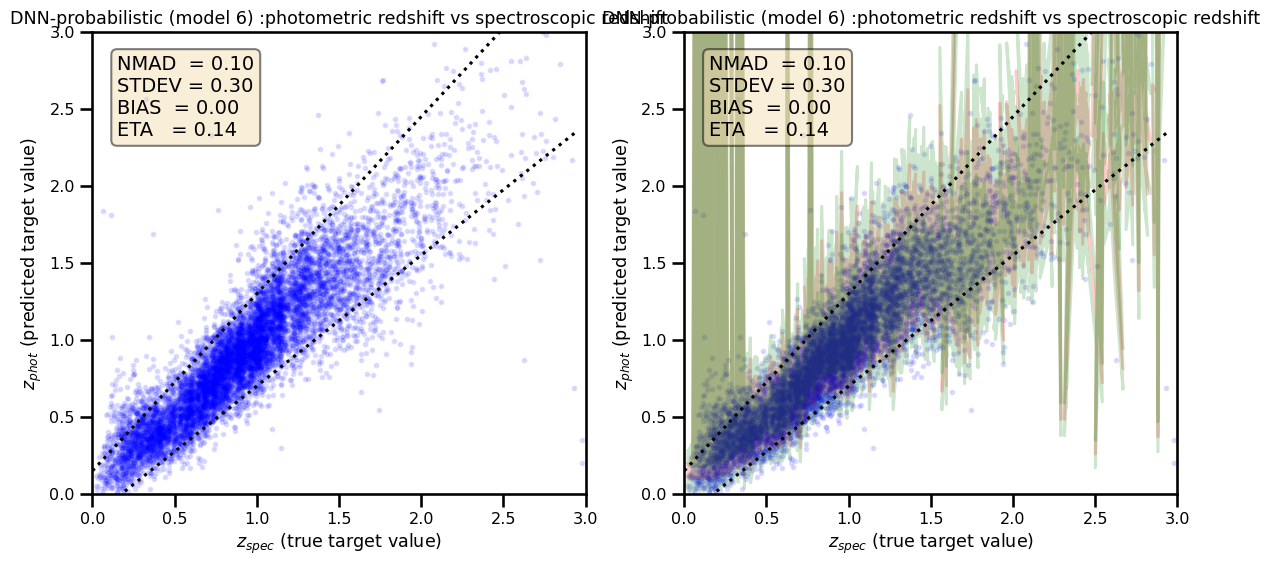

In [77]:
fig=plt.figure(figsize=(14,6))

#------
ax=fig.add_subplot(1,2,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 6) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

#-----
ax=fig.add_subplot(1,2,2)
y_sample = model6(x_train).sample()
y_hat = model6(x_train).mean()
y_sd = model6(x_train).stddev()
y_hat_lower = y_hat - 1 * y_sd
y_hat_upper = y_hat + 1 * y_sd

ax.plot(y_train,y_hat,'r-',alpha=0.2)
ax.plot(y_train,y_hat_lower,'g-',alpha=0.2)
ax.plot(y_train,y_hat_upper,'g-',alpha=0.2)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 6) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

# Model 7

In [78]:
def get_model_v7(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(12, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(48, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n4')(x)
    x = keras.layers.Dense(12, activation="relu", name='Dense_n5')(x)
    x = tfp.layers.DenseVariational(12 + 12, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational32')(x)
    x = keras.layers.Dense(1,  name='Dense_n6')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [79]:
n_samples = x_train.shape[0]
model7 = get_model_v7(n_samples)

In [80]:
model7.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 6)]               0         
                                                                 
 Dense_n1 (Dense)            (None, 12)                84        
                                                                 
 Dense_n2 (Dense)            (None, 24)                312       
                                                                 
 Dense_n3 (Dense)            (None, 48)                1200      
                                                                 
 Dense_n4 (Dense)            (None, 24)                1176      
                                                                 
 Dense_n5 (Dense)            (None, 12)                300       
                                                                 
 DenseVariational32 (DenseV  (None, 24)                936 

In [81]:
# Fit
history = model7.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

Epoch 1/200
593/593 [==============================] - 5s 4ms/step - loss: 3.0387 - val_loss: 1.5936 - lr: 0.0100
Epoch 2/200
593/593 [==============================] - 2s 3ms/step - loss: 1.3044 - val_loss: 1.1866 - lr: 0.0100
Epoch 3/200
593/593 [==============================] - 2s 3ms/step - loss: 1.1635 - val_loss: 1.0960 - lr: 0.0100
Epoch 4/200
593/593 [==============================] - 1s 2ms/step - loss: 1.1254 - val_loss: 1.0122 - lr: 0.0100
Epoch 5/200
593/593 [==============================] - 1s 2ms/step - loss: 0.9325 - val_loss: 0.8837 - lr: 0.0100
Epoch 6/200
593/593 [==============================] - 1s 2ms/step - loss: 0.8119 - val_loss: 0.8041 - lr: 0.0100
Epoch 7/200
593/593 [==============================] - 2s 3ms/step - loss: 0.7548 - val_loss: 0.7780 - lr: 0.0100
Epoch 8/200
593/593 [==============================] - 2s 3ms/step - loss: 0.7303 - val_loss: 0.6972 - lr: 0.0100
Epoch 9/200
593/593 [==============================] - 2s 3ms/step - loss: 0.7062 - val_

Text(0.5, 1.0, 'Model 7 : Loss')

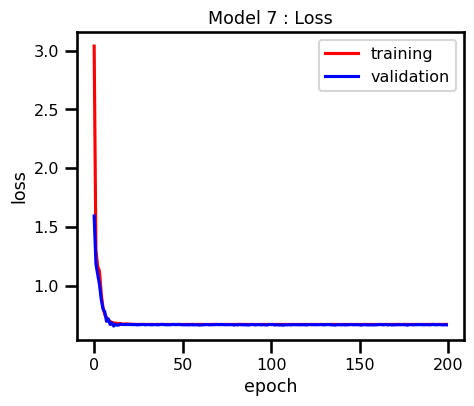

In [82]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 7 : Loss")
#ax.set_yscale('log')

In [83]:
y_pred_train = model7(x_train).sample()
y_pred_test = model7(x_test).sample()

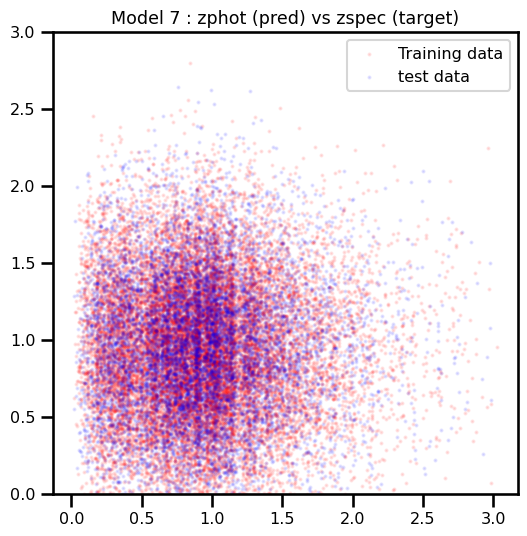

In [84]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 7 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [85]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 0.3668
Normalized MAD: 0.3411
Delta z >0.15(1+z) outliers: 66.386 percent
Median offset:  0.010 +/-  0.005


In [86]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

(0.0, 3.0)

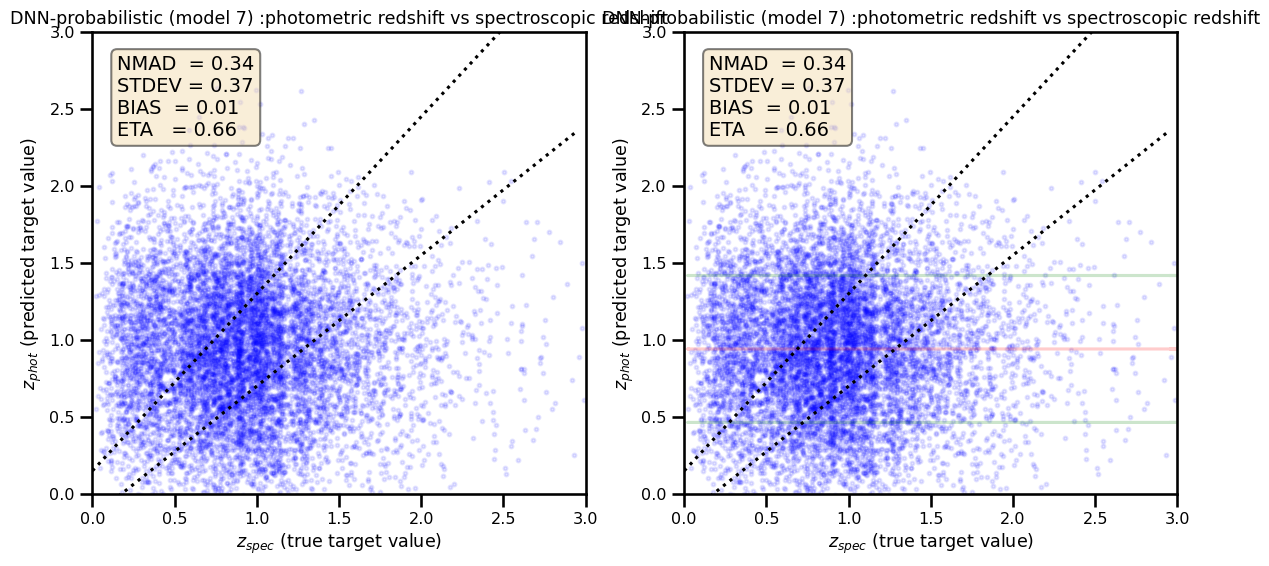

In [87]:
fig=plt.figure(figsize=(14,6))

#------
ax=fig.add_subplot(1,2,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 7) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

#-----
ax=fig.add_subplot(1,2,2)
y_sample = model7(x_train).sample()
y_hat = model7(x_train).mean()
y_sd = model7(x_train).stddev()
y_hat_lower = y_hat - 1 * y_sd
y_hat_upper = y_hat + 1 * y_sd

ax.plot(y_train,y_hat,'r-',alpha=0.2)
ax.plot(y_train,y_hat_lower,'g-',alpha=0.2)
ax.plot(y_train,y_hat_upper,'g-',alpha=0.2)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 7) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

# Model 8

In [88]:
def get_model_v8(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(12, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n2')(x)
    x = keras.layers.Dense(48, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n4')(x)
    x = keras.layers.Dense(12, activation="relu", name='Dense_n5')(x)
    x = tfp.layers.DenseVariational(12 + 12, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational12')(x)
    #x = keras.layers.Dense(1,  name='Dense_n6')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [89]:
n_samples = x_train.shape[0]
model8 = get_model_v8(n_samples)

In [90]:
model8.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 6)]               0         
                                                                 
 Dense_n1 (Dense)            (None, 12)                84        
                                                                 
 Dense_n2 (Dense)            (None, 24)                312       
                                                                 
 Dense_n3 (Dense)            (None, 48)                1200      
                                                                 
 Dense_n4 (Dense)            (None, 24)                1176      
                                                                 
 Dense_n5 (Dense)            (None, 12)                300       
                                                                 
 DenseVariational12 (DenseV  (None, 24)                936 

In [91]:
# Fit
history = model8.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

Epoch 1/200
593/593 [==============================] - 5s 4ms/step - loss: 187319.3906 - val_loss: 410.0677 - lr: 0.0100
Epoch 2/200
593/593 [==============================] - 3s 4ms/step - loss: 103.6453 - val_loss: 264.6850 - lr: 0.0100
Epoch 3/200
593/593 [==============================] - 3s 6ms/step - loss: 34901.9648 - val_loss: 14.6360 - lr: 0.0100
Epoch 4/200
593/593 [==============================] - 4s 7ms/step - loss: 17.0448 - val_loss: 50.0220 - lr: 0.0100
Epoch 5/200
593/593 [==============================] - 4s 7ms/step - loss: 5.6005 - val_loss: 4.1722 - lr: 0.0100
Epoch 6/200
593/593 [==============================] - 3s 4ms/step - loss: 21.5204 - val_loss: 8.7378 - lr: 0.0100
Epoch 7/200
593/593 [==============================] - 4s 6ms/step - loss: 11.7388 - val_loss: 6.8901 - lr: 0.0100
Epoch 8/200
593/593 [==============================] - 4s 7ms/step - loss: 4.2994 - val_loss: 16.5991 - lr: 0.0100
Epoch 9/200
593/593 [==============================] - 2s 3ms/step 

(-1.0, 5.0)

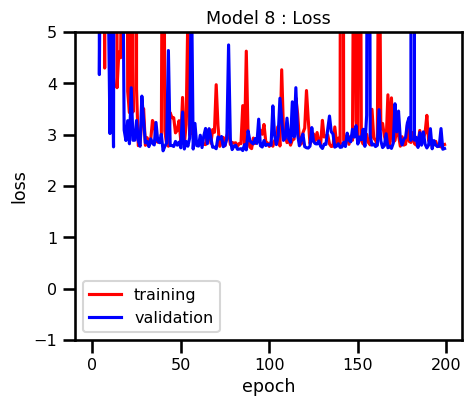

In [92]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 8 : Loss")
ax.set_ylim(-1,5)
#ax.set_yscale('log')

In [93]:
y_pred_train = model8(x_train).sample()
y_pred_test = model8(x_test).sample()

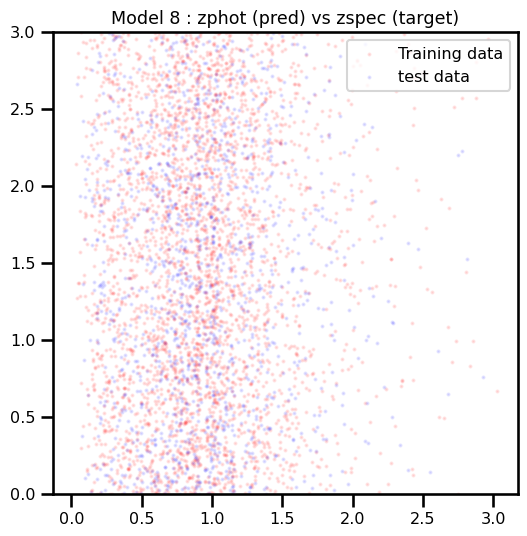

In [94]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 8 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [95]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 3.5011
Normalized MAD: 4.0172
Delta z >0.15(1+z) outliers: 97.119 percent
Median offset: -2.101 +/-  0.045


In [96]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

(0.0, 3.0)

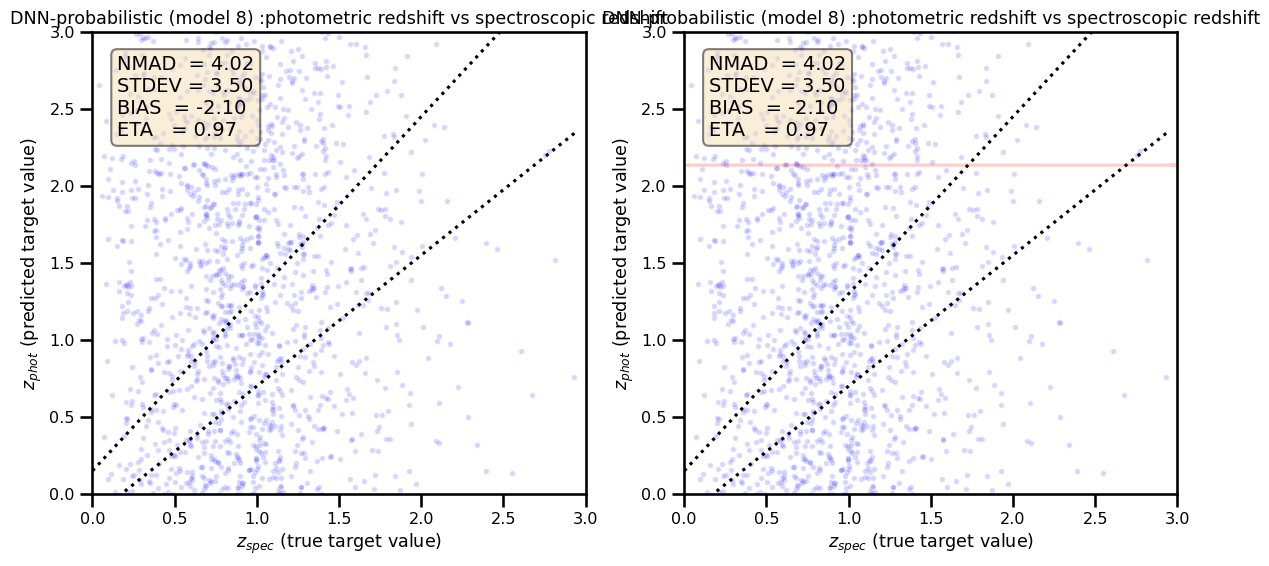

In [97]:
fig=plt.figure(figsize=(14,6))

#------
ax=fig.add_subplot(1,2,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 8) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

#-----
ax=fig.add_subplot(1,2,2)
y_sample = model8(x_train).sample()
y_hat = model8(x_train).mean()
y_sd = model8(x_train).stddev()
y_hat_lower = y_hat - 1 * y_sd
y_hat_upper = y_hat + 1 * y_sd

ax.plot(y_train,y_hat,'r-',alpha=0.2)
ax.plot(y_train,y_hat_lower,'g-',alpha=0.2)
ax.plot(y_train,y_hat_upper,'g-',alpha=0.2)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 8) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

# Model 9

In [117]:
def get_model_v9(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(12, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n2')(x)
    #x = keras.layers.Dense(48, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n4')(x)
    x = keras.layers.Dense(12, activation="relu", name='Dense_n5')(x)
    x = tfp.layers.DenseVariational(12 + 12, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational12')(x)
    #x = tfp.layers.DenseVariational(6 + 6, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational6')(x)
    
    #x = keras.layers.Dense(1,  name='Dense_n6')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [118]:
n_samples = x_train.shape[0]
model9 = get_model_v9(n_samples)

In [119]:
model9.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 6)]               0         
                                                                 
 Dense_n1 (Dense)            (None, 12)                84        
                                                                 
 Dense_n2 (Dense)            (None, 24)                312       
                                                                 
 Dense_n4 (Dense)            (None, 24)                600       
                                                                 
 Dense_n5 (Dense)            (None, 12)                300       
                                                                 
 DenseVariational12 (DenseV  (None, 24)                936       
 ariational)                                                     
                                                           

In [120]:
# Fit
history = model9.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

Epoch 1/200
593/593 [==============================] - 4s 3ms/step - loss: 8016.6929 - val_loss: 14.6055 - lr: 0.0100
Epoch 2/200
593/593 [==============================] - 1s 2ms/step - loss: 11.2946 - val_loss: 15.5994 - lr: 0.0100
Epoch 3/200
593/593 [==============================] - 1s 2ms/step - loss: 20.3944 - val_loss: 5.1985 - lr: 0.0100
Epoch 4/200
593/593 [==============================] - 1s 2ms/step - loss: 6.5995 - val_loss: 5.4236 - lr: 0.0100
Epoch 5/200
593/593 [==============================] - 1s 2ms/step - loss: 317.7293 - val_loss: 3.0556 - lr: 0.0100
Epoch 6/200
593/593 [==============================] - 1s 2ms/step - loss: 3.3546 - val_loss: 3.3237 - lr: 0.0100
Epoch 7/200
593/593 [==============================] - 2s 3ms/step - loss: 2.5085 - val_loss: 4.8920 - lr: 0.0100
Epoch 8/200
593/593 [==============================] - 2s 3ms/step - loss: 6.3256 - val_loss: 2.6616 - lr: 0.0100
Epoch 9/200
593/593 [==============================] - 2s 3ms/step - loss: 2.79

(-1.0, 5.0)

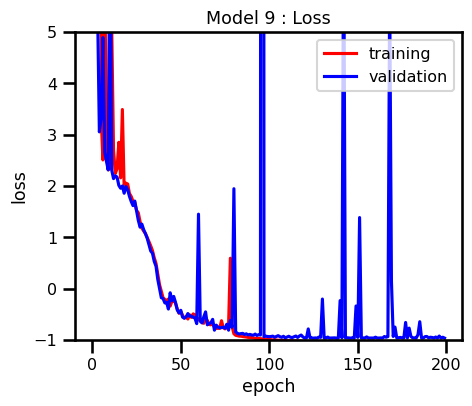

In [121]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 9 : Loss")
ax.set_ylim(-1,5)
#ax.set_yscale('log')

In [122]:
y_pred_train = model9(x_train).sample()
y_pred_test = model9(x_test).sample()

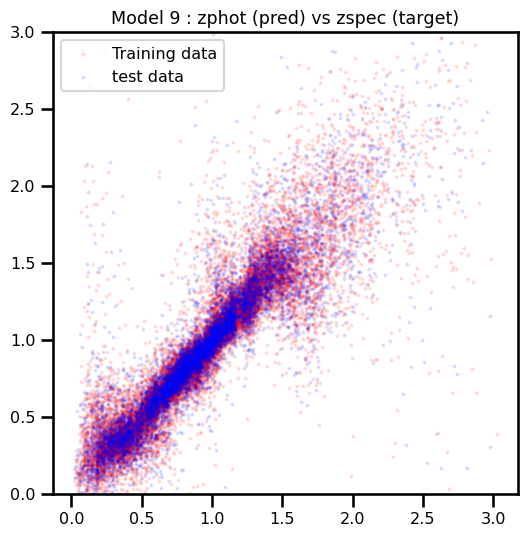

In [123]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 9 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [124]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 0.1225
Normalized MAD: 0.0531
Delta z >0.15(1+z) outliers:  9.705 percent
Median offset:  0.000 +/-  0.002


In [125]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

(0.0, 3.0)

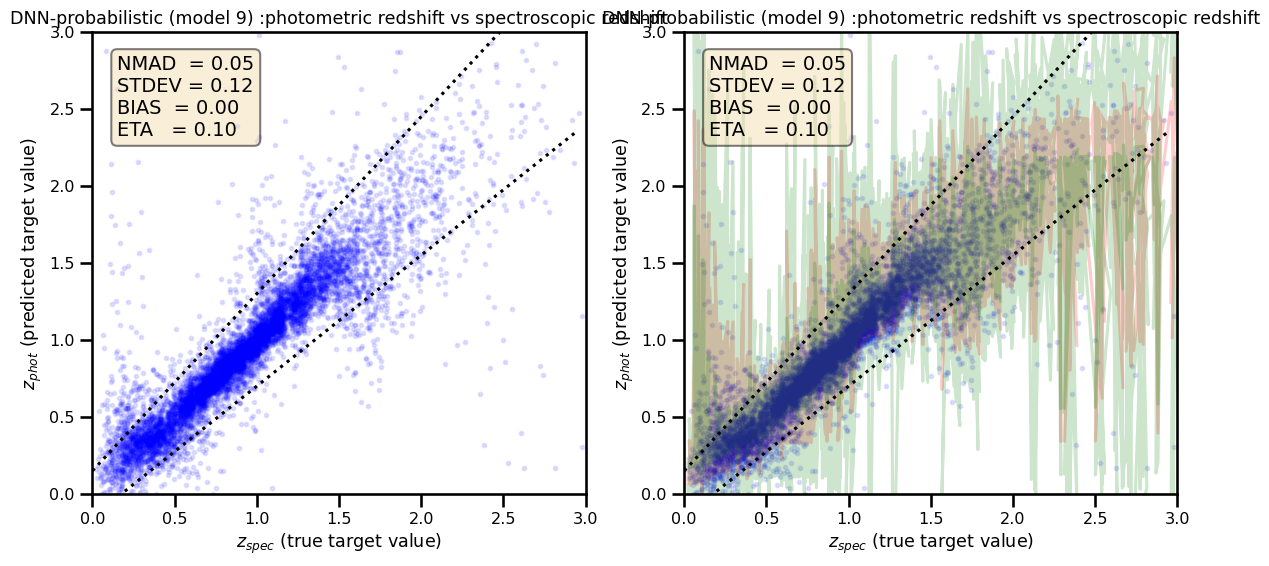

In [126]:
fig=plt.figure(figsize=(14,6))

#------
ax=fig.add_subplot(1,2,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 9) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

#-----
ax=fig.add_subplot(1,2,2)
y_sample = model9(x_train).sample()
y_hat = model9(x_train).mean()
y_sd = model9(x_train).stddev()
y_hat_lower = y_hat - 1 * y_sd
y_hat_upper = y_hat + 1 * y_sd

ax.plot(y_train,y_hat,'r-',alpha=0.2)
ax.plot(y_train,y_hat_lower,'g-',alpha=0.2)
ax.plot(y_train,y_hat_upper,'g-',alpha=0.2)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 9) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

# Model 10

In [135]:
def get_model_v10(n_samples):
    
    input_tensor = keras.layers.Input((6,), name="InputLayer")
    x = keras.layers.Dense(12, activation='relu', name='Dense_n1')(input_tensor)
    x = keras.layers.Dense(24, activation='relu', name='Dense_n2')(x)
    #x = keras.layers.Dense(48, activation='relu', name='Dense_n3')(x)
    x = keras.layers.Dense(12, activation='relu', name='Dense_n4')(x)
    x = keras.layers.Dense(6, activation="relu", name='Dense_n5')(x)
    x = tfp.layers.DenseVariational(6 + 6, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational12')(x)
    #x = tfp.layers.DenseVariational(6 + 6, posterior_mean_field, prior_trainable, kl_weight=1/n_samples,activation='sigmoid',name='DenseVariational6')(x)
    
    #x = keras.layers.Dense(1,  name='Dense_n6')(x)
    
    x = tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior_trainable,
                              make_posterior_fn=posterior_mean_field,
                              kl_use_exact=False,
                              kl_weight=1/n_samples)(x)

    # Aleatoric uncertainty    
    output_proba = tfpl.IndependentNormal(1)(x)
    
    
    model = Model(input_tensor,output_proba)
  
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss      = negloglik )
    return model

In [136]:
n_samples = x_train.shape[0]
model10 = get_model_v10(n_samples)

In [ ]:
# Fit
history = model10.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks = callbacks_list)

Epoch 1/200
593/593 [==============================] - 4s 3ms/step - loss: 611.0858 - val_loss: 75.2573 - lr: 0.0100
Epoch 2/200
593/593 [==============================] - 1s 2ms/step - loss: 12.3251 - val_loss: 16.4803 - lr: 0.0100
Epoch 3/200
593/593 [==============================] - 2s 3ms/step - loss: 22.4345 - val_loss: 14.6137 - lr: 0.0100
Epoch 4/200
593/593 [==============================] - 2s 3ms/step - loss: 9.7936 - val_loss: 6.2831 - lr: 0.0100
Epoch 5/200
593/593 [==============================] - 2s 3ms/step - loss: 12.4109 - val_loss: 15.5502 - lr: 0.0100
Epoch 6/200
593/593 [==============================] - 1s 2ms/step - loss: 9.2072 - val_loss: 5.5593 - lr: 0.0100
Epoch 7/200
593/593 [==============================] - 1s 2ms/step - loss: 14.1627 - val_loss: 2.4767 - lr: 0.0100
Epoch 8/200
593/593 [==============================] - 1s 2ms/step - loss: 2.7491 - val_loss: 3.1599 - lr: 0.0100
Epoch 9/200
593/593 [==============================] - 1s 2ms/step - loss: 5.1

(-1.0, 5.0)

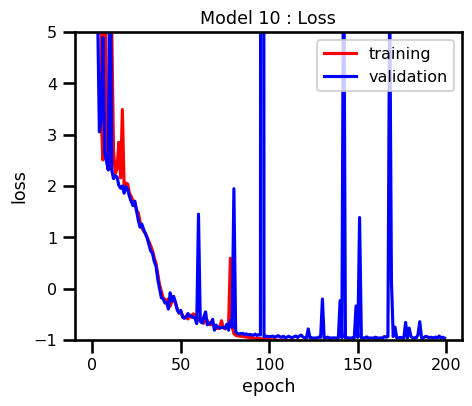

In [132]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Model 10 : Loss")
ax.set_ylim(-1,5)
#ax.set_yscale('log')

In [133]:
y_pred_train = model10(x_train).sample()
y_pred_test = model10(x_test).sample()

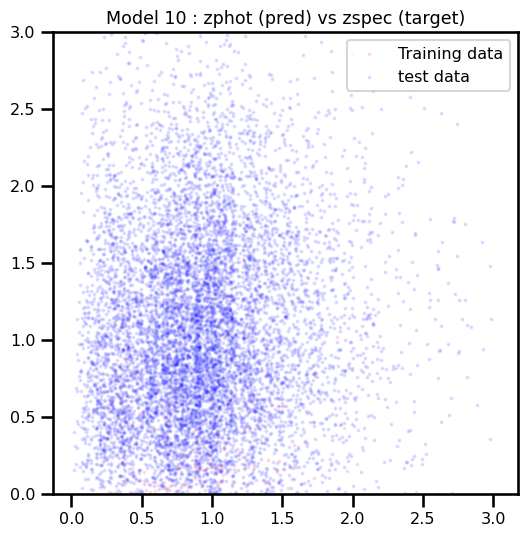

In [134]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', s=2,label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', s=2,label='test data')
ax.set_title("Model 10 : zphot (pred) vs zspec (target)")
ax.set_ylim(0,3)
ax.legend()

In [114]:
z_spec = y_test
z_phot = y_pred_test
nmad,std_result,bias,eta,stats_txt = get_stats(z_spec,z_phot,slope=0.15)

Standard Deviation: 0.1278
Normalized MAD: 0.0628
Delta z >0.15(1+z) outliers: 11.040 percent
Median offset: -0.001 +/-  0.002


In [115]:
x,outlier_upper,outlier_lower = plot_lines(zmin=0,zmax=3,zstep=0.05,slope=0.15)

(0.0, 3.0)

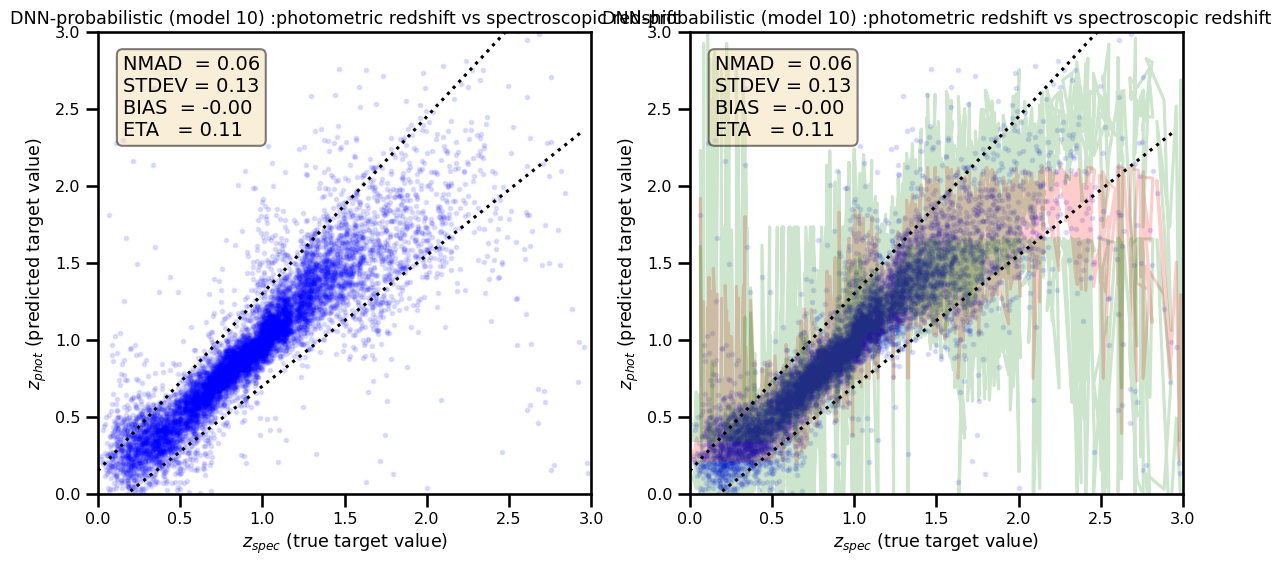

In [116]:
fig=plt.figure(figsize=(14,6))

#------
ax=fig.add_subplot(1,2,1)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 10) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)

#-----
ax=fig.add_subplot(1,2,2)
y_sample = model10(x_test).sample()
y_hat = model10(x_test).mean()
y_sd = model10(x_test).stddev()
y_hat_lower = y_hat - 1 * y_sd
y_hat_upper = y_hat + 1 * y_sd

ax.plot(y_test,y_hat,'r-',alpha=0.2)
ax.plot(y_test,y_hat_lower,'g-',alpha=0.2)
ax.plot(y_test,y_hat_upper,'g-',alpha=0.2)
ax.scatter(z_spec,z_phot,marker='.',c="b",s=30,alpha=0.1)
ax.text(0.05, 0.95, stats_txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("$z_{spec}$ (true target value)")
ax.set_ylabel("$z_{phot}$ (predicted target value)")
ax.set_title("DNN-probabilistic (model 10) :photometric redshift vs spectroscopic redshift")
ax.plot(x,outlier_upper,'k:')
ax.plot(x,outlier_lower,'k:')
ax.set_ylim(0,3)
ax.set_xlim(0,3)